In [2]:
#!unzip '/Users/thrilok/Desktop/Datasets/kermany2018.zip'

In [3]:
import cv2
import tensorflow as tf

In [4]:
train_path = "/Users/thrilok/Documents/computer-vision/OCT2017 /train"
val_path = "/Users/thrilok/Documents/computer-vision/OCT2017 /val"
test_path = "/Users/thrilok/Documents/computer-vision/OCT2017 /test"

In [5]:
from tqdm import tqdm
from PIL import Image
import os


X_train = []
Y_train = []

for target in os.listdir(train_path):
    target_path = os.path.join(train_path,target)
    for file in tqdm(os.listdir(target_path)):
        file_path = os.path.join(target_path,file)
        X_train.append(file_path)
        Y_train.append(target)

100%|████████████████████████████████████████████████████| 26315/26315 [00:00<00:00, 1297209.96it/s]


In [6]:
X_val = []
Y_val = []

for target in os.listdir(val_path):
    target_path = os.path.join(val_path,target)
    for file in tqdm(os.listdir(target_path)):
        file_path = os.path.join(target_path,file)
        X_val.append(file_path)
        Y_val.append(target)

100%|█████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 241398.79it/s]


In [7]:
X_test = []
Y_test = []

for target in os.listdir(test_path):
    target_path = os.path.join(test_path,target)
    for file in tqdm(os.listdir(target_path)):
        file_path = os.path.join(target_path,file)
        X_test.append(file_path)
        Y_test.append(target)

100%|█████████████████████████████████████████████████████████| 242/242 [00:00<00:00, 279466.29it/s]


<AxesSubplot:ylabel='count'>

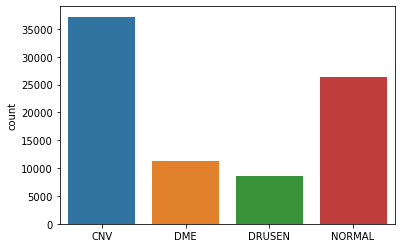

In [8]:
import seaborn as sns
sns.countplot(x = Y_train)

In [10]:
import pandas as pd
df_train = pd.DataFrame(list(zip(X_train, Y_train)), columns =['image_path', 'label'])
df_val = pd.DataFrame(list(zip(X_val,Y_val)), columns=['image_path','label'])
df_test = pd.DataFrame(list(zip(X_test,Y_test)), columns=['image_path','label'])

In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_aug = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    rescale = 1./255,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

test_aug = ImageDataGenerator(
    rescale = 1./255,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

train_generator= train_aug.flow_from_dataframe(
    dataframe=df_train,
    x_col="image_path",
    y_col="label",
    batch_size=16,
    color_mode="rgb",
    target_size = (224, 224),
    class_mode="categorical")

val_generator= test_aug.flow_from_dataframe(
    dataframe=df_val,
    x_col="image_path",
    y_col="label",
    batch_size=16,
    color_mode="rgb",
    target_size = (224, 224),
    class_mode="categorical")

test_generator= test_aug.flow_from_dataframe(
    dataframe=df_test,
    x_col="image_path",
    y_col="label",
    color_mode="rgb",
    batch_size=16,
    shuffle = False, 
    target_size = (224, 224),
    class_mode="categorical")

Found 83484 validated image filenames belonging to 4 classes.
Found 32 validated image filenames belonging to 4 classes.
Found 968 validated image filenames belonging to 4 classes.


In [22]:
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D,AveragePooling2D, BatchNormalization, PReLU, ReLU
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
# from keras.applications import InceptionResNetV2

def generate_model(pretrained_model = 'vgg16', num_classes=4):
    if pretrained_model == 'inceptionv3':
        base_model = InceptionV3(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))
    elif pretrained_model == 'inceptionresnet':
        base_model = InceptionResNetV2(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        base_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3)) # Topless
    
    x = base_model.output
    x = Flatten()(x)
    x = Dense(4096)(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Dense(4096)(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    #Freezing Convolutional Base
    for layer in base_model.layers[:-3]:
        layer.trainable = False  
    return model

In [23]:
def train_model(model, train_generator, test_generator, num_epochs, optimizer, metrics):
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=metrics)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=6, verbose=1)
    rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=7)
    print(model.summary())
    
    history = model.fit(train_generator, epochs=num_epochs, 
                        validation_data=test_generator, verbose=1,
                        callbacks = [early_stop, rlr])
    
    return model, history


In [24]:
import itertools
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

metrics = ['accuracy',
                tf.keras.metrics.AUC(),
                tfa.metrics.CohenKappa(num_classes = 4),
                tfa.metrics.F1Score(num_classes = 4),
                tf.keras.metrics.Precision(), 
                tf.keras.metrics.Recall()]

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
# It prints & plots the confusion matrix, normalization can be applied by setting normalize=True.
    
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):

    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_roc_curves(y_true, y_pred, num_classes, class_labels):
    
    lb = LabelBinarizer()
    lb.fit(y_true)
    y_test = lb.transform(y_true)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    for i in range(num_classes):
        fig, c_ax = plt.subplots(1,1, figsize = (6, 4))
        c_ax.plot(fpr[i], tpr[i],
                 label='ROC curve of class {0} (area = {1:0.4f})'
                 ''.format(class_labels[i], roc_auc[i]))
        c_ax.set_xlabel('False Positive Rate')
        c_ax.set_ylabel('True Positive Rate')
        c_ax.set_title('ROC curve of class {0}'.format(class_labels[i]))
        c_ax.legend(loc="lower right")
        plt.show()
    return roc_auc_score(y_test, y_pred)

In [25]:
def evaluate_model(model, history, test_generator):
    # Evaluate model
    score = model.evaluate(test_generator, verbose=0)
    print('\nTest set accuracy:', score[1], '\n')
    
    y_true = np.array(test_generator.labels)
    y_pred = model.predict(test_generator, verbose = 1)
    y_pred_classes = np.argmax(y_pred,axis = 1)
    class_labels = list(test_generator.class_indices.keys())   
    
    print('\n', sklearn.metrics.classification_report(y_true, y_pred_classes, target_names=class_labels), sep='')
    confusion_mtx = confusion_matrix(y_true, y_pred_classes)
    plot_acc(history)
    plt.show()
    plot_loss(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = class_labels)
    plt.show()
    print("ROC AUC score:", plot_roc_curves(y_true, y_pred, 4, class_labels))


In [26]:
vgg_model = generate_model('vgg16',4)

In [ ]:
vgg_model, vgg_history = train_model(vgg_model, train_generator, val_generator, 50, tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), metrics)

/Users/thrilok/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-09-05 22:20:01.527292: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

2022-09-05 22:20:02.423331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 419/5218 [=>............................] - ETA: 2:03:40 - loss: 1876148443870781704765440.0000 - accuracy: 0.4558 - auc_4: 0.6960 - cohen_kappa: 8.7839e-04 - f1_score: 0.1649 - precision_3: 0.3032 - recall_3: 0.0070

In [ ]:
evaluate_model(vgg_model, vgg_history, test_generator)